Engie Project

Last Update: June 15, 2021

Notes: two cases -- one with EP ratio enforced, one without that constraint

Run Time:

In [1]:
### Initialize
import DataFrames, CSV, Plots, JuMP, Gurobi

In [2]:
##Reading in Data
using CSV, DataFrames
Data = CSV.read("Data.csv", DataFrame, normalizenames=true)

,hour,heating_kW_th_h_m2_,PV_electricity_kW,Wind_electricity_kW,Demand_kW
,Float64?,Float64?,Float64?,Float64?,Float64?
1,1.0,0.0,0.0,0.0839,1664.74
2,2.0,0.0001,0.0,0.0839,1551.21
3,3.0,0.0,0.0,0.0839,1429.02
4,4.0,0.0012,0.0,0.0839,1350.95
5,5.0,0.0081,0.0,0.0839,1324.06
6,6.0,0.009,0.0,0.0839,1296.71
7,7.0,0.0139,0.0,0.0839,1597.59
8,8.0,0.0194,0.0,0.1533,1479.02
9,9.0,0.0171,0.0,0.1533,1791.12


In [58]:
##Saving Columns as their variables
ElecDemand = Data[1:8760,5] #kW
ElecDemand = identity.(ElecDemand)

PVMaxPower = 4500 ##kW, 4.5 MW Max Capacity Installed
PV = Data[1:8760,3] #kW/kW Installed
PV = identity.(PV)*PVMaxPower ##KW

Cost_Elec = Data[1:8760,6] 
Cost_Elec = identity.(Cost_Elec)

8760-element Array{Float64,1}:
 0.0689
 0.065
 0.0603
 0.05
 0.0477
 0.048
 0.0498
 0.0551
 0.0448
 0.0496
 0.0554
 0.0626
 0.0574
 ⋮
 0.0386
 0.0379
 0.038
 0.0396
 0.0423
 0.0461
 0.0477
 0.046
 0.0422
 0.0397
 0.0389
 0.0372

Long Term Variables (Investment Variables) :
E_Rated = Battery Rated Capacity
P_Rated = Battery Rated Power
Binary 1: Invest in Battery
Binary 2: Don't Invest in Battery

Short Term Variables (Operational Variables):
EState_Batt = Battery State of Charge at Time t
PState_Batt = Battery Power at Time t
P_Grid = Power Consumed/ Injected to the grid

Parameters

Cost_BattE = Investment Cost of Battery, energy component

Cost_BattP = Investment cost of battery, power 

Cost_OM= Fixed yearly operation and maintenance costs

DiscountRate = discount rate, werighted average cost of capital

Cost_Electricity = Price of Electricity (optional binary)

In [59]:
using JuMP, Gurobi

model = Model(Gurobi.Optimizer)
## Short Term Variables
@variable(model,P_Batt[1:8760],container=Array)
@variable(model,P_Grid[1:8760],container=Array)

@variable(model, P_Sell[1:8760], container=Array)
@variable(model, P_Buy[1:8760], container=Array)
@variable(model, mu[1:8760], binary=true)
@variable(model,E_Batt[1:8760],container=Array)

##long term variables
@variable(model, E_Rated)
@variable(model,P_Rated)

Academic license - for non-commercial use only - expires 2021-08-04


P_Rated

In [60]:
##Battery Investment Costs
CostEnergy = 300 ##euros/kWh
CostPower = 300 ##euros/kW
BIVC = E_Rated*CostEnergy + P_Rated*CostPower

300 E_Rated + 300 P_Rated

In [61]:
## Present Value of O&M Costs
CostOM = 20.5 ## Eurp/kWh/Yr
#Investment Horizon
Y= 3
Discount_Rate = .0025
OMC=0
for y in Y
    OMC = OMC+(E_Rated*CostOM)/(1+Discount_Rate)^y
end

In [62]:
##Residual Value of Battery at end of investment horizon
DepreciationTime = 10 # Years, from excel sheet
ResidVal = (1-Y/DepreciationTime)*BIVC

210 E_Rated + 210 P_Rated

In [63]:
SellingPrice = 0.3 ##Edit this as needed
BuySellTotalCost=0
for y in Y
    BuySellCost = P_Buy.* Cost_Elec +P_Sell.*Cost_Elec*SellingPrice
    BuySellTotalCost = BuySellTotalCost + sum(BuySellCost)/(1+Discount_Rate)^y
end
TotalCost = BuySellTotalCost + OMC+ BIVC - ResidVal

@objective(model, Min, TotalCost)

0.06838582302460529 P_Buy[1] + 0.020515746907381584 P_Sell[1] + 0.0645149273817031 P_Buy[2] + 0.019354478214510928 P_Sell[2] + 0.05985000186333379 P_Buy[3] + 0.017955000559000137 P_Sell[3] + 0.04962686721669469 P_Buy[4] + 0.014888060165008406 P_Sell[4] + 0.04734403132472673 P_Buy[5] + 0.01420320939741802 P_Sell[5] + 0.0476417925280269 P_Buy[6] + 0.01429253775840807 P_Sell[6] + 0.04942835974782791 P_Buy[7] + 0.014828507924348372 P_Sell[7] + 0.05468880767279755 P_Buy[8] + 0.016406642301839264 P_Sell[8] + 0.04446567302615844 P_Buy[9] + 0.01333970190784753 P_Sell[9] + 0.04922985227896113 P_Buy[10] + 0.014768955683688339 P_Sell[10] + 0.054986568876097715 P_Buy[11] + 0.016495970662829314 P_Sell[11] + 0.062132837755301755 P_Buy[12] + 0.018639851326590528 P_Sell[12] + 0.0569716435647655 P_Buy[13] + 0.01709149306942965 P_Sell[13] + 0.0504208970921618 P_Buy[14] + 0.015126269127648539 P_Sell[14] + 0.0495276134822613 P_Buy[15] + 0.014858284044678389 P_Sell[15] + 0.04972612095112808 P_Buy[16] + 0.0

# Power Balance Constraints

In [64]:
##Power Balance
@constraint(model,[i = 1:8760],-ElecDemand[i]+PV[i]+P_Batt[i]+P_Grid[i]==0)
# + if pulling from supply, ex P_Batt = +5 means taking 5kW from battery -5 would be saving 5kw

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.EqualTo{Float64}},ScalarShape},1}:
 P_Batt[1] + P_Grid[1] == 1664.7351
 P_Batt[2] + P_Grid[2] == 1551.2123
 P_Batt[3] + P_Grid[3] == 1429.0156
 P_Batt[4] + P_Grid[4] == 1350.9513
 P_Batt[5] + P_Grid[5] == 1324.0599
 P_Batt[6] + P_Grid[6] == 1296.7088
 P_Batt[7] + P_Grid[7] == 1597.5924
 P_Batt[8] + P_Grid[8] == 1479.0196
 P_Batt[9] + P_Grid[9] == 1791.1166
 P_Batt[10] + P_Grid[10] == 1588.4041000000002
 P_Batt[11] + P_Grid[11] == 1357.5196
 P_Batt[12] + P_Grid[12] == 1266.7476
 P_Batt[13] + P_Grid[13] == 1000.5099
 ⋮
 P_Batt[8749] + P_Grid[8749] == 3149.4159999999997
 P_Batt[8750] + P_Grid[8750] == 3342.503
 P_Batt[8751] + P_Grid[8751] == 3495.7809
 P_Batt[8752] + P_Grid[8752] == 3444.2838
 P_Batt[8753] + P_Grid[8753] == 2612.4831
 P_Batt[8754] + P_Grid[8754] == 2419.4783
 P_Batt[8755] + P_Grid[8755] == 2069.2717
 P_Batt[8756] + P_Grid[8756] == 1889.30

# Battery Constraints

In [65]:
##Start with a full battery
@constraint((model),E_Batt[1] <= E_Rated)

E_Batt[1] - E_Rated <= 0.0

In [66]:
## 1 Rated energy and power must be between the min and max
P_Max = 100000 ##kW from excel
P_Min = 600 ##kW from excel
@constraint(model, P_Min <= P_Rated <= P_Max)

P_Rated in [600.0, 100000.0]

In [67]:
## 2 Energy Constraints based on EP ratio
#MaxEPRatio=10 ## Ratio from Excel
#MinEPRatio=0.25 ##Ratio from Excel
#@constraint(model, (P_Rated*MinEPRatio)<= E_Rated)
#@constraint(model, (P_Rated*MaxEPRatio)>= E_Rated)

In [68]:
## 3 Battery power at time t cannot exceed Rated Power
@constraint(model, [ i=1:8760], P_Batt[i].<= P_Rated)
@constraint(model, [ i=1:8760], P_Batt[i].>= -P_Rated)

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.GreaterThan{Float64}},ScalarShape},1}:
 P_Batt[1] + P_Rated >= 0.0
 P_Batt[2] + P_Rated >= 0.0
 P_Batt[3] + P_Rated >= 0.0
 P_Batt[4] + P_Rated >= 0.0
 P_Batt[5] + P_Rated >= 0.0
 P_Batt[6] + P_Rated >= 0.0
 P_Batt[7] + P_Rated >= 0.0
 P_Batt[8] + P_Rated >= 0.0
 P_Batt[9] + P_Rated >= 0.0
 P_Batt[10] + P_Rated >= 0.0
 P_Batt[11] + P_Rated >= 0.0
 P_Batt[12] + P_Rated >= 0.0
 P_Batt[13] + P_Rated >= 0.0
 ⋮
 P_Batt[8749] + P_Rated >= 0.0
 P_Batt[8750] + P_Rated >= 0.0
 P_Batt[8751] + P_Rated >= 0.0
 P_Batt[8752] + P_Rated >= 0.0
 P_Batt[8753] + P_Rated >= 0.0
 P_Batt[8754] + P_Rated >= 0.0
 P_Batt[8755] + P_Rated >= 0.0
 P_Batt[8756] + P_Rated >= 0.0
 P_Batt[8757] + P_Rated >= 0.0
 P_Batt[8758] + P_Rated >= 0.0
 P_Batt[8759] + P_Rated >= 0.0
 P_Batt[8760] + P_Rated >= 0.0

In [69]:
## Battery State of Charge Updating with RT Eff and Dissipation Rate
RTEff = 0.90  ## from excel
DissipationRt = 0.00004 ## from excel

@constraint(model, [ i=2:8760], E_Batt[i] == (1-DissipationRt)*E_Batt[i-1]-P_Batt[i]*sqrt(RTEff))

1-dimensional DenseAxisArray{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.EqualTo{Float64}},ScalarShape},1,...} with index sets:
    Dimension 1, 2:8760
And data, a 8759-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.EqualTo{Float64}},ScalarShape},1}:
 0.9486832980505138 P_Batt[2] - 0.99996 E_Batt[1] + E_Batt[2] == 0.0
 0.9486832980505138 P_Batt[3] - 0.99996 E_Batt[2] + E_Batt[3] == 0.0
 0.9486832980505138 P_Batt[4] - 0.99996 E_Batt[3] + E_Batt[4] == 0.0
 0.9486832980505138 P_Batt[5] - 0.99996 E_Batt[4] + E_Batt[5] == 0.0
 0.9486832980505138 P_Batt[6] - 0.99996 E_Batt[5] + E_Batt[6] == 0.0
 0.9486832980505138 P_Batt[7] - 0.99996 E_Batt[6] + E_Batt[7] == 0.0
 0.9486832980505138 P_Batt[8] - 0.99996 E_Batt[7] + E_Batt[8] == 0.0
 0.9486832980505138 P_Batt[9] - 0.99996 E_Batt[8] + E_Batt[9] == 0.0
 0.9486832980505138 P_Batt[10] - 0.99996

In [70]:
## Charging/discharging power constraints
@constraint(model, [i=1:8760], P_Batt[i] <= P_Rated)
@constraint(model, [i=1:8760], P_Batt[i] >= -P_Rated)

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.GreaterThan{Float64}},ScalarShape},1}:
 P_Batt[1] + P_Rated >= 0.0
 P_Batt[2] + P_Rated >= 0.0
 P_Batt[3] + P_Rated >= 0.0
 P_Batt[4] + P_Rated >= 0.0
 P_Batt[5] + P_Rated >= 0.0
 P_Batt[6] + P_Rated >= 0.0
 P_Batt[7] + P_Rated >= 0.0
 P_Batt[8] + P_Rated >= 0.0
 P_Batt[9] + P_Rated >= 0.0
 P_Batt[10] + P_Rated >= 0.0
 P_Batt[11] + P_Rated >= 0.0
 P_Batt[12] + P_Rated >= 0.0
 P_Batt[13] + P_Rated >= 0.0
 ⋮
 P_Batt[8749] + P_Rated >= 0.0
 P_Batt[8750] + P_Rated >= 0.0
 P_Batt[8751] + P_Rated >= 0.0
 P_Batt[8752] + P_Rated >= 0.0
 P_Batt[8753] + P_Rated >= 0.0
 P_Batt[8754] + P_Rated >= 0.0
 P_Batt[8755] + P_Rated >= 0.0
 P_Batt[8756] + P_Rated >= 0.0
 P_Batt[8757] + P_Rated >= 0.0
 P_Batt[8758] + P_Rated >= 0.0
 P_Batt[8759] + P_Rated >= 0.0
 P_Batt[8760] + P_Rated >= 0.0

In [71]:
## 5 Energy constraints with depth of discharge
DOD = 0.9
@constraint(model, [i=1:8760], (1-DOD)*E_Rated <= E_Batt[i])
@constraint(model, [i=1:8760],  E_Batt[i] <= E_Rated)

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1}:
 E_Batt[1] - E_Rated <= 0.0
 E_Batt[2] - E_Rated <= 0.0
 E_Batt[3] - E_Rated <= 0.0
 E_Batt[4] - E_Rated <= 0.0
 E_Batt[5] - E_Rated <= 0.0
 E_Batt[6] - E_Rated <= 0.0
 E_Batt[7] - E_Rated <= 0.0
 E_Batt[8] - E_Rated <= 0.0
 E_Batt[9] - E_Rated <= 0.0
 E_Batt[10] - E_Rated <= 0.0
 E_Batt[11] - E_Rated <= 0.0
 E_Batt[12] - E_Rated <= 0.0
 E_Batt[13] - E_Rated <= 0.0
 ⋮
 E_Batt[8749] - E_Rated <= 0.0
 E_Batt[8750] - E_Rated <= 0.0
 E_Batt[8751] - E_Rated <= 0.0
 E_Batt[8752] - E_Rated <= 0.0
 E_Batt[8753] - E_Rated <= 0.0
 E_Batt[8754] - E_Rated <= 0.0
 E_Batt[8755] - E_Rated <= 0.0
 E_Batt[8756] - E_Rated <= 0.0
 E_Batt[8757] - E_Rated <= 0.0
 E_Batt[8758] - E_Rated <= 0.0
 E_Batt[8759] - E_Rated <= 0.0
 E_Batt[8760] - E_Rated <= 0.0

# Grid Constraints -- Until 2024

In [72]:
## 6 Grid can only provide 2MW = 2000 kW until 2024
@constraint(model, [i=1:8760],-2000 <= P_Grid[i])
@constraint(model, [i=1:8760],P_Grid[i] <= 2000)

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1}:
 P_Grid[1] <= 2000.0
 P_Grid[2] <= 2000.0
 P_Grid[3] <= 2000.0
 P_Grid[4] <= 2000.0
 P_Grid[5] <= 2000.0
 P_Grid[6] <= 2000.0
 P_Grid[7] <= 2000.0
 P_Grid[8] <= 2000.0
 P_Grid[9] <= 2000.0
 P_Grid[10] <= 2000.0
 P_Grid[11] <= 2000.0
 P_Grid[12] <= 2000.0
 P_Grid[13] <= 2000.0
 ⋮
 P_Grid[8749] <= 2000.0
 P_Grid[8750] <= 2000.0
 P_Grid[8751] <= 2000.0
 P_Grid[8752] <= 2000.0
 P_Grid[8753] <= 2000.0
 P_Grid[8754] <= 2000.0
 P_Grid[8755] <= 2000.0
 P_Grid[8756] <= 2000.0
 P_Grid[8757] <= 2000.0
 P_Grid[8758] <= 2000.0
 P_Grid[8759] <= 2000.0
 P_Grid[8760] <= 2000.0

In [73]:
## Binary, for buying and selling
@constraint(model, [i=1:8760], P_Grid[i]==P_Sell[i]+P_Buy[i]) ##either selling or buying
##Ex. Selling = -5 kw cannot exceed -2000kW
@constraint(model, [i=1:8760], -PV[i] <= P_Sell[i]) ## Selling only from PV production
@constraint(model, [i=1:8760], -2000*mu[i] <= P_Sell[i])
@constraint(model, [i=1:8760], P_Sell[i] <= 0)
@constraint(model, [i=1:8760], 0 <= P_Buy[i])
@constraint(model, [i=1:8760], P_Buy[i] <= 2000*(1-mu[i]))

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1}:
 P_Buy[1] + 2000 mu[1] <= 2000.0
 P_Buy[2] + 2000 mu[2] <= 2000.0
 P_Buy[3] + 2000 mu[3] <= 2000.0
 P_Buy[4] + 2000 mu[4] <= 2000.0
 P_Buy[5] + 2000 mu[5] <= 2000.0
 P_Buy[6] + 2000 mu[6] <= 2000.0
 P_Buy[7] + 2000 mu[7] <= 2000.0
 P_Buy[8] + 2000 mu[8] <= 2000.0
 P_Buy[9] + 2000 mu[9] <= 2000.0
 P_Buy[10] + 2000 mu[10] <= 2000.0
 P_Buy[11] + 2000 mu[11] <= 2000.0
 P_Buy[12] + 2000 mu[12] <= 2000.0
 P_Buy[13] + 2000 mu[13] <= 2000.0
 ⋮
 P_Buy[8749] + 2000 mu[8749] <= 2000.0
 P_Buy[8750] + 2000 mu[8750] <= 2000.0
 P_Buy[8751] + 2000 mu[8751] <= 2000.0
 P_Buy[8752] + 2000 mu[8752] <= 2000.0
 P_Buy[8753] + 2000 mu[8753] <= 2000.0
 P_Buy[8754] + 2000 mu[8754] <= 2000.0
 P_Buy[8755] + 2000 mu[8755] <= 2000.0
 P_Buy[8756] + 2000 mu[8756] <= 2000.0
 P_Buy[8757] + 2000 mu[8757] <= 2000.0
 P_Buy[8758] + 2000 mu[8758] <= 2000.

In [74]:
optimize!(model)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 140161 rows, 52563 columns and 254041 nonzeros
Model fingerprint: 0xeac5289d
Variable types: 43803 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+03]
  Objective range  [3e-05, 1e+02]
  Bounds range     [6e+02, 1e+05]
  RHS range        [1e-01, 4e+03]
Presolve removed 100625 rows and 29700 columns
Presolve time: 1.13s
Presolved: 39536 rows, 22863 columns, 110294 nonzeros
Variable types: 18621 continuous, 4242 integer (4242 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.14s

Solved with dual simplex

Root relaxation: objective 7.166002e+07, 9437 iterations, 2.12 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Tim

In [75]:
println("Optimal Solutions:")
println("Total Cost = ", value(TotalCost)/1e6, " Million")
println("Rated Battery Power = ", value(P_Rated)/1000," MW")
println("Actual Discharge Power Needed= ", value(maximum(P_Batt_Optimized)/1000), "MW")
println("Actual Charging Power Needed= ", value(minimum(P_Batt_Optimized)/1000), "MW")
println("Battery Cap = ", value(E_Rated)/1000," MWh")

Optimal Solutions:
Total Cost = 71.66002190617226 Million
Rated Battery Power = 1.9696915100828296 MW
Actual Discharge Power Needed= 1.9696915100828296MW
Actual Charging Power Needed= -1.9696915100828296MW
Battery Cap = 641.9006155776314 MWh


In [76]:
E_Batt_Optimized = JuMP.value.(E_Batt)
P_Batt_Optimized = JuMP.value.(P_Batt)
P_Grid_Optimized = JuMP.value.(P_Grid)
P_Buy_Optimized = JuMP.value.(P_Buy)
P_Sell_Optimized = JuMP.value.(P_Sell)

8760-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

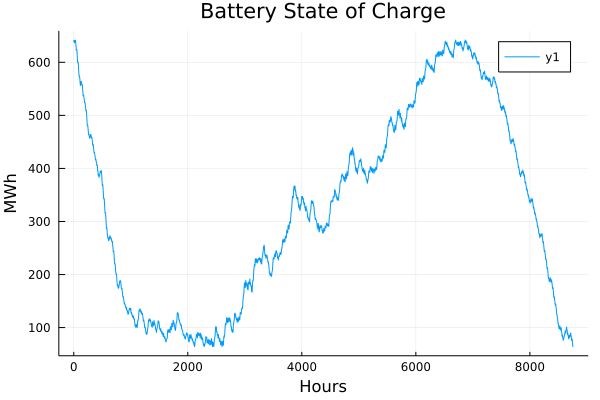

In [77]:
##Battery State of Charge 
using Plots
x = 1:8760
plot(x,E_Batt_Optimized/1000, title = "Battery State of Charge")
xlabel!("Hours")
ylabel!("MWh")

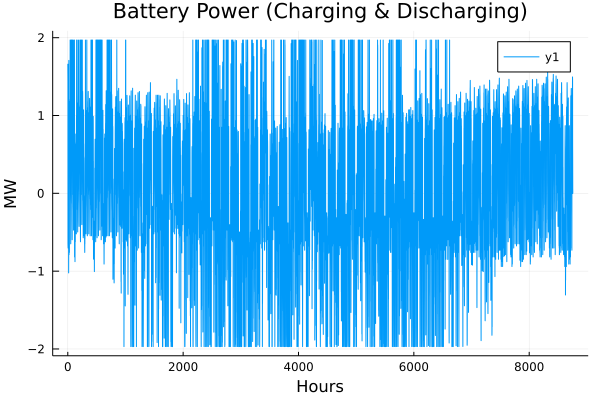

In [78]:
plot(x,P_Batt_Optimized/1000, title = "Battery Power (Charging & Discharging)")
xlabel!("Hours")
ylabel!("MW")

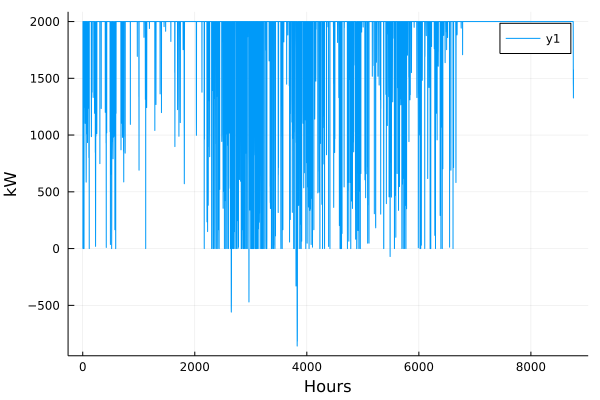

In [79]:
plot(x, P_Grid_Optimized)
xlabel!("Hours")
ylabel!("kW")

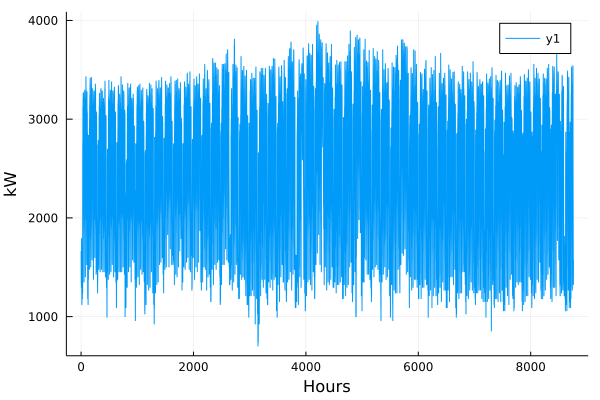

In [80]:
##checking that demand is met
plot(x, ElecDemand)
check = P_Grid_Optimized + P_Batt_Optimized + PV

xlabel!("Hours")
ylabel!("kW")

In [81]:
using DataFrames
df = DataFrame( E_Batt = E_Batt_Optimized,
                P_Batt = P_Batt_Optimized,
                P_Grid = P_Grid_Optimized,
                P_Buy = P_Buy_Optimized,
                P_Sell = P_Sell_Optimized,
                Demand = ElecDemand,
                PV = PV,
                Binary = JuMP.value.(mu)
               )

,E_Batt,P_Batt,P_Grid,P_Buy,P_Sell,Demand,PV,Binary
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,6.41901e5,1664.74,0.0,0.0,0.0,1664.74,0.0,0.0
2,6.40403e5,1551.21,0.0,0.0,0.0,1551.21,0.0,0.0
3,639022.0,1429.02,0.0,0.0,0.0,1429.02,0.0,0.0
4,6.39612e5,-649.049,2000.0,2000.0,0.0,1350.95,0.0,0.0
5,6.40228e5,-675.94,2000.0,2000.0,0.0,1324.06,0.0,0.0
6,6.40869e5,-703.291,2000.0,2000.0,0.0,1296.71,0.0,0.0
7,6.41226e5,-402.408,2000.0,2000.0,0.0,1597.59,0.0,0.0
8,6.39797e5,1479.02,0.0,0.0,0.0,1479.02,0.0,0.0
9,6.39969e5,-208.883,2000.0,2000.0,0.0,1791.12,0.0,0.0


In [82]:
using CSV
CSV.write("Desktop\\OTESoutputnew.csv", df)

"Desktop\\OTESoutputnew.csv"